# Machine Learning in Chess to Study Patterns in Chess Games


## Import Libraries


In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


## Load the Data


In [2]:
DATA_PATH = "/Users/isaac/Dropbox/Documents/University/Year 4/Project (ECM3401)/ChessDBs/lichess_db_standard_rated_2022"
# Check whether the DataFrame has been loaded correctly.
df = dd.read_parquet(DATA_PATH, engine="pyarrow")
print(f"Loaded {len(df)} Rated Bullet, Rated Blitz, and Rated Rapid games from 2022.\n")
display(df)
display(df.head())


Loaded 63927025 Rated Bullet, Rated Blitz, and Rated Rapid games from 2022.



,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
npartitions=153,,,,,,,,,,,,
,datetime64[ns],category[unknown],string,category[unknown],category[unknown],string,string,string,string,int16,int16,string
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
0,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Normal,D02,Queen's Pawn Game: Chigorin Variation,Kike73,Aox066,1255,1252,https://lichess.org/BPNsj2LF
1,2022-01-01 00:00:11,Rated Bullet game,120+1,1-0,Normal,C40,King's Pawn Game: Busch-Gass Gambit,schachueli,HiddenEyes,1346,1308,https://lichess.org/ooDjyGrm
2,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Time forfeit,C02,"French Defense: Advance Variation, Nimzowitsch...",Renf7,Euphorbe92,859,964,https://lichess.org/T4TIdZZM
3,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Time forfeit,B10,Caro-Kann Defense: Accelerated Panov Attack,Ralza63,FN2718,1769,1702,https://lichess.org/Oz5OFohi
4,2022-01-01 00:00:11,Rated Bullet game,120+1,1-0,Time forfeit,A41,Queen's Pawn Game,arkchess1963,sirkkeli,2146,2196,https://lichess.org/iehbAAzy


## Filter the Data


In [3]:
num_games_before_filtering = len(df)
# Remove games that were aborted.
df = df[(df["Termination"] != "Abandoned") & (df["Event"] != "Rated Bullet game")]
display(df.head())
print(f"Filtered out {num_games_before_filtering - len(df)} games that were aborted.\n")


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
7,2022-01-01 00:00:11,Rated Rapid game,600+0,1-0,Normal,B00,"Nimzowitsch Defense: Scandinavian Variation, A...",shahzad97,mpasha98,1500,1205,https://lichess.org/UMMGcaGz
8,2022-01-01 00:00:11,Rated Blitz game,300+3,0-1,Normal,D00,Queen's Pawn Game: Mason Variation,nicolas_clos,pangma,1430,1412,https://lichess.org/yJI78ET0
9,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,E97,"King's Indian Defense: Orthodox Variation, Aro...",oyuka79,JUAN121,2422,2292,https://lichess.org/mrPOJU0W
10,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,C22,Center Game: Berger Variation,manoharkatwa,RigoBam,1241,1221,https://lichess.org/YJ1AIn03
11,2022-01-01 00:00:12,Rated Blitz game,300+0,0-1,Time forfeit,A40,Modern Defense,raffrantic1,Carly001,1044,1091,https://lichess.org/RATgKCCm


Filtered out 23805297 games that were aborted.



## Get Distribution of Player Ratings


In [4]:
# Merge the counts into one, as the player's side isn't important.
white_rating_count = df["WhiteElo"].value_counts().compute()
black_rating_count = df["BlackElo"].value_counts().compute()
rating_counts = (
    pd.concat([white_rating_count, black_rating_count], axis=1).fillna(0).astype(int)
)
rating_counts = rating_counts.sum(axis=1)
# Find the minimum and maximum player rating.
max_rating = rating_counts.index.max()
min_rating = rating_counts.index.min()
print(f"Maximum player rating: {max_rating}")
print(f"Minimum player rating: {min_rating}")

# Define the bin edges for player ratings from 600 (minimum in Lichess) to the
# maximum in intervals of 200.
bin_size = 200
rating_bins = np.array([i for i in range(600, max_rating + bin_size, bin_size)])
rating_counts.index = pd.cut(rating_counts.index, bins=rating_bins)
merged_rating_counts = rating_counts.groupby(level=0).sum()
display(merged_rating_counts)


Maximum player rating: 3485
Minimum player rating: 600


(600, 800]        687535
(800, 1000]      3156347
(1000, 1200]     7207254
(1200, 1400]    11272801
(1400, 1600]    14835190
(1600, 1800]    16155957
(1800, 2000]    14200749
(2000, 2200]     8550908
(2200, 2400]     3183947
(2400, 2600]      817814
(2600, 2800]      142142
(2800, 3000]       11622
(3000, 3200]         382
(3200, 3400]          42
(3400, 3600]           1
dtype: int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_85863/4275098620.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(indexes, rotation=60)


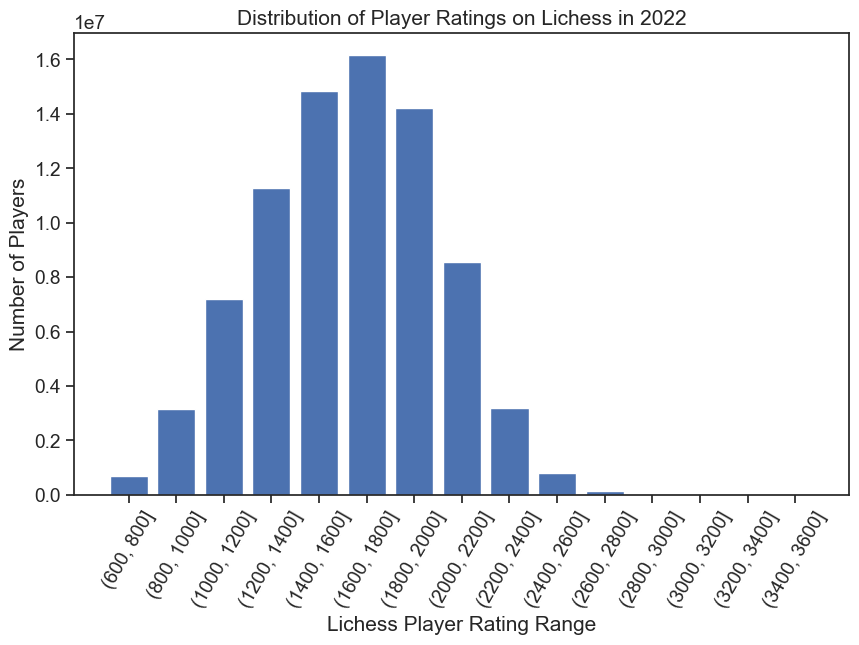

In [5]:
# Plot a graph to show the distribution of player ratings.
sns.set("talk")
sns.set(font_scale=1.25)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = merged_rating_counts.index.astype(str)
values = merged_rating_counts.values
ax.bar(indexes, values)
ax.set_title("Distribution of Player Ratings on Lichess in 2022")
ax.set_xlabel("Lichess Player Rating Range")
ax.set_ylabel("Number of Players")
ax.set_xticklabels(indexes, rotation=60)
plt.show()


## Get Most Popular Openings by Category


### All Rated Players

In [6]:
# Find the most common ECO categories.
eco_categories = df["ECO"].str[0].value_counts().compute()
print("All Players:")
display(eco_categories)


All Players:


C    14070192
B    11256591
A     8653831
D     5478963
E      629352
?       32799
Name: ECO, dtype: Int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_85863/2372787079.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


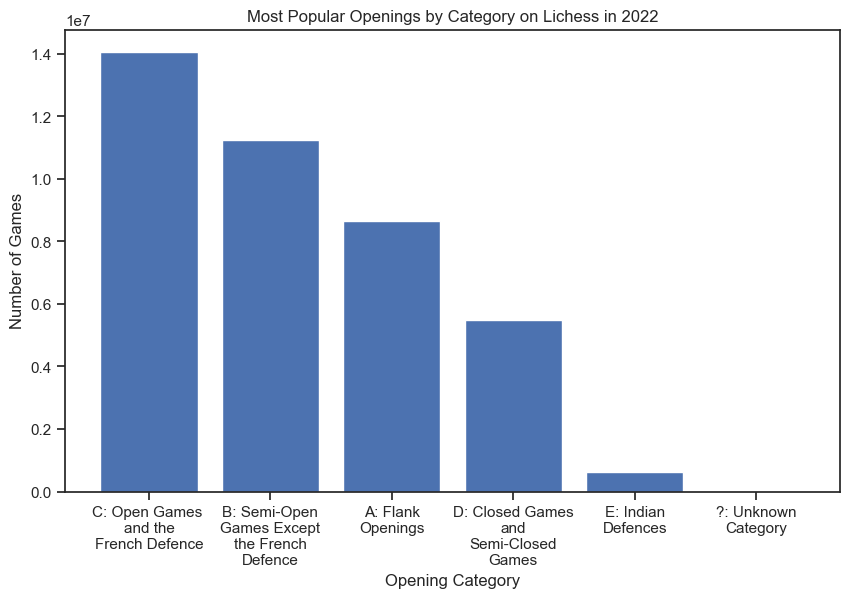

In [7]:
# Map each opening category to its type.
opening_category_map = {
    "A": "Flank\nOpenings",
    "B": "Semi-Open\nGames Except\nthe French\nDefence",
    "C": "Open Games \nand the\nFrench Defence",
    "D": "Closed Games\nand\nSemi-Closed\nGames",
    "E": "Indian\nDefences",
    "?": "Unknown\nCategory",
}

# Plot the number of games in each opening category.
sns.set("talk")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = eco_categories.index
values = eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### High Rated Players (Rating 2000+)


Players with Rating 2000 and Above:


B    2176694
A    1675378
C    1352678
D     902553
E     269989
?       5467
Name: ECO, dtype: Int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_85863/1324326008.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


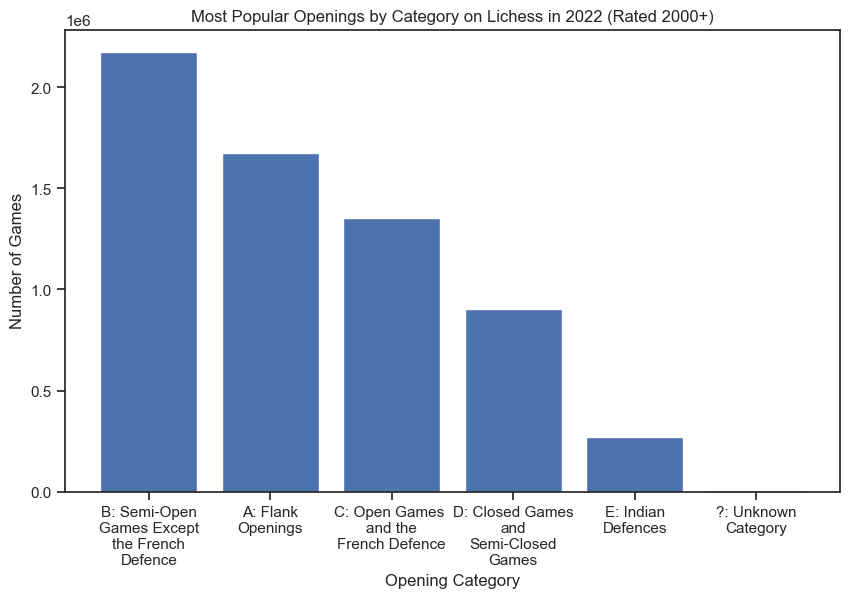

In [8]:
# Find the most common ECO categories for players rated 2000 and above.
high_rated_eco_categories = (
    df[df["WhiteElo"] >= 2000]["ECO"].str[0].value_counts().compute()
)
print("Players with Rating 2000 and Above:")
display(high_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set("talk")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = high_rated_eco_categories.index
values = high_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022 (Rated 2000+)")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### Mid Rated Players (Rating 1201-1999)


Players with Rating 1201-1999:


C    10228118
B     7905666
A     5844439
D     3859371
E      346316
?       19882
Name: ECO, dtype: Int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_85863/4025140517.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


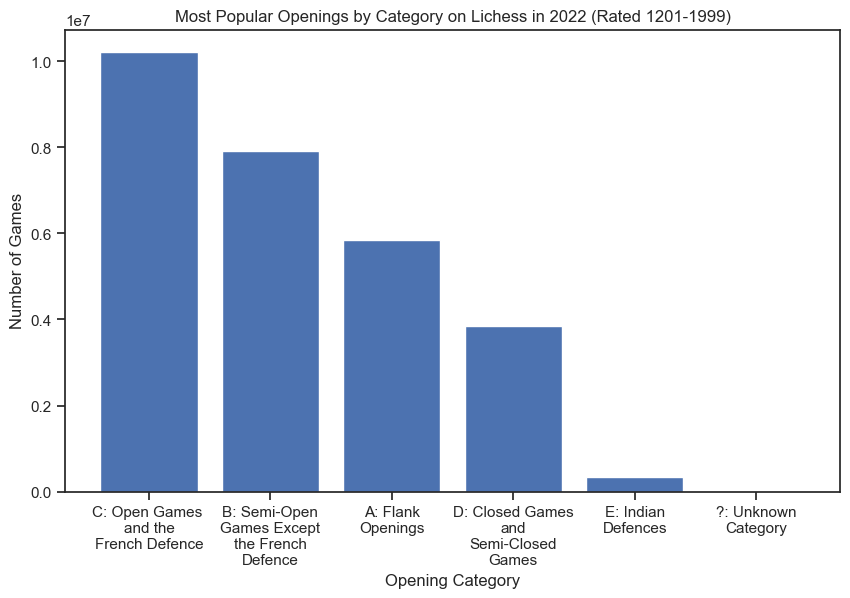

In [9]:
# Find the most common ECO categories for players rated 1401-1999.
mid_rated_eco_categories = (
    df[(df["WhiteElo"] >= 1201) & (df["WhiteElo"] <= 1999)]["ECO"]
    .str[0]
    .value_counts()
    .compute()
)
print("Players with Rating 1201-1999:")
display(mid_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set("talk")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = mid_rated_eco_categories.index
values = mid_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022 (Rated 1201-1999)")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()


### Low Rated Players (Rating 1200 and Below)


Players with Rating 1200 and Below:


C    2489396
B    1174231
A    1134014
D     717039
E      13047
?       7450
Name: ECO, dtype: Int64

/var/folders/qp/xjhbjb791c527d9nwvbnwz8m0000gn/T/ipykernel_85863/3004672445.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


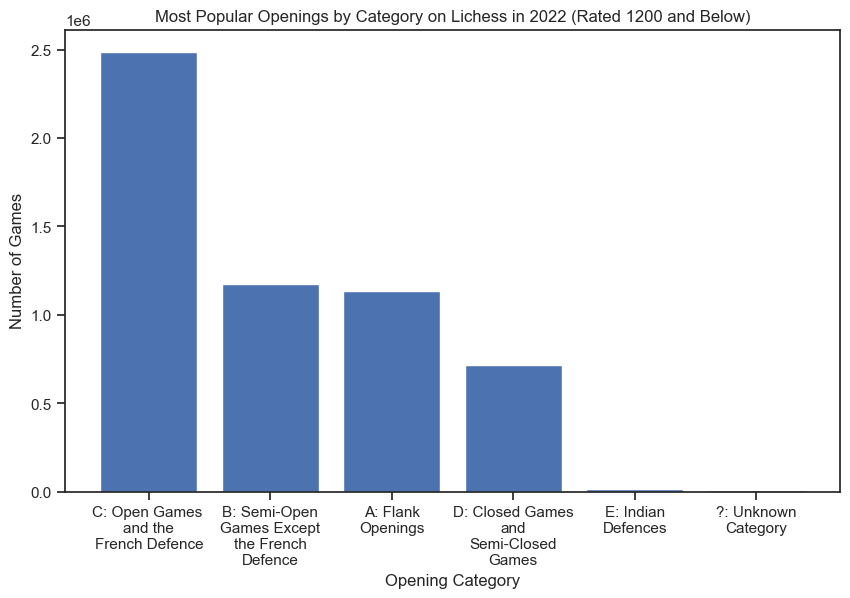

In [10]:
# Find the most common ECO categories for players rated 1400 and below.
low_rated_eco_categories = (
    df[df["WhiteElo"] <= 1200]["ECO"].str[0].value_counts().compute()
)
print("Players with Rating 1200 and Below:")
display(low_rated_eco_categories)

# Plot the number of games in each opening category.
sns.set("talk")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = low_rated_eco_categories.index
values = low_rated_eco_categories.values
ax.bar(indexes, values)
ax.set_title("Most Popular Openings by Category on Lichess in 2022 (Rated 1200 and Below)")
ax.set_xlabel("Opening Category")
ax.set_ylabel("Number of Games")
ax.set_xticklabels(
    [str(f"{index}: {opening_category_map[index]}") for index in indexes]
)
plt.show()

## Get Most Popular Openings


### All Rated Players


In [11]:
# Group variations of the same opening together by splitting on the colon.
opening_groups = df["Opening"].str.split(":").str[0].value_counts().compute()
display(opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
top_15_openings = opening_groups[:15]
top_15_openings_proportion = top_15_openings.sum() / opening_groups.sum()
print(
    f"The top 15 openings account for {top_15_openings_proportion:.2%} of all "
    "games on Lichess in 2022."
)


Sicilian Defense        4492781
Queen's Pawn Game       3403077
French Defense          2266247
Scandinavian Defense    1979982
Italian Game            1868665
                         ...   
Venezolana Opening           29
Formation                    24
Dresden Opening              16
Amar Gambit                  15
Veresov Opening               9
Name: Opening, Length: 162, dtype: int64

The top 15 openings account for 63.68% of all games on Lichess in 2022.


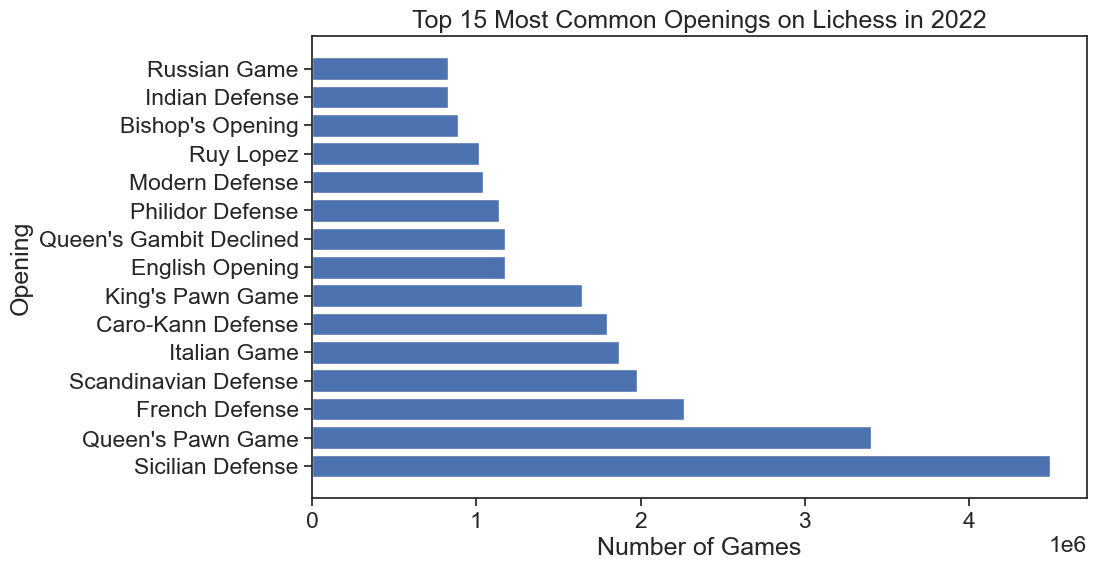

In [12]:
# Plot the top 15 most common openings.
sns.set("talk")
sns.set(font_scale=1.5)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = opening_groups.index[:15]
values = opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### High Rated Players (Rating 2000+)


Sicilian Defense      1080298
French Defense         429823
Queen's Pawn Game      409113
Caro-Kann Defense      376911
English Opening        311541
                       ...   
English Rat                 6
Amsterdam Attack            3
Venezolana Opening          2
Veresov Opening             2
Tayler Opening              1
Name: Opening, Length: 161, dtype: int64

The top 15 openings for players rated 2000+ account for 10.80% of all games on Lichess in 2022.


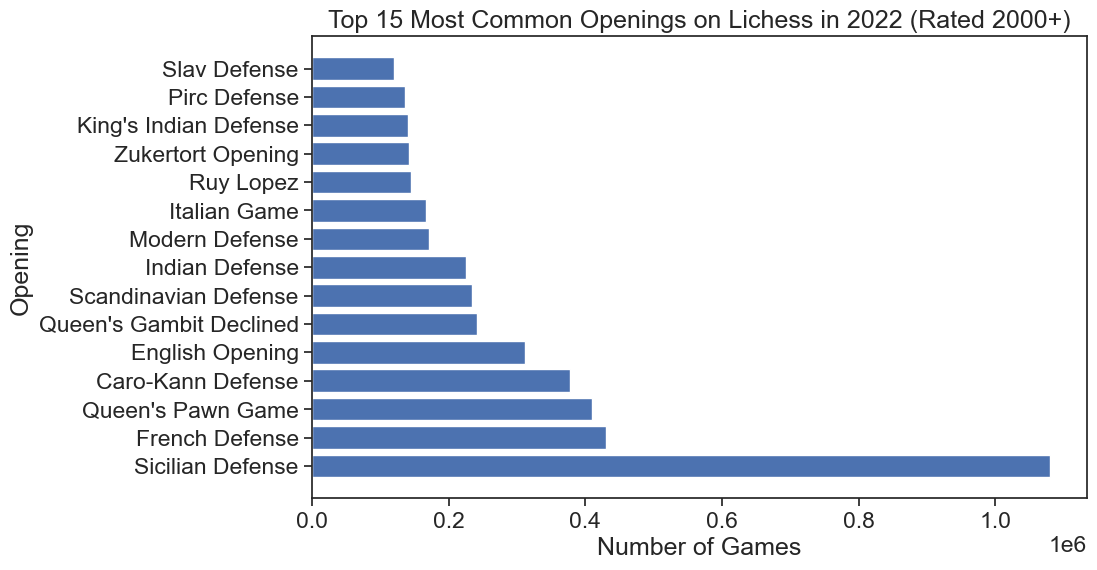

In [13]:
# Group variations of the same opening together by splitting on the colon.
high_rated_opening_groups = (
    df[df["WhiteElo"] >= 2000]["Opening"].str.split(":").str[0].value_counts().compute()
)
display(high_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
high_rated_top_15_openings = high_rated_opening_groups[:15]
high_rated_top_15_openings_proportion = (
    high_rated_top_15_openings.sum() / opening_groups.sum()
)
print(
    "The top 15 openings for players rated 2000+ account for "
    f"{high_rated_top_15_openings_proportion:.2%} of all games on Lichess in "
    "2022."
)

# Plot the top 15 most common openings.
sns.set("talk")
sns.set(font_scale=1.5)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = high_rated_opening_groups.index[:15]
values = high_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 2000+)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### Mid Rated Players (Rating 1201-1999)


Sicilian Defense                     3144923
Queen's Pawn Game                    2406971
French Defense                       1594203
Italian Game                         1442963
Scandinavian Defense                 1414562
                                      ...   
Blumenfeld Countergambit Accepted         16
Formation                                 12
Dresden Opening                            6
Veresov Opening                            5
Amar Gambit                                2
Name: Opening, Length: 162, dtype: int64

The top 15 openings for players rated 1201-1999 account for 45.47% of all games on Lichess in 2022.


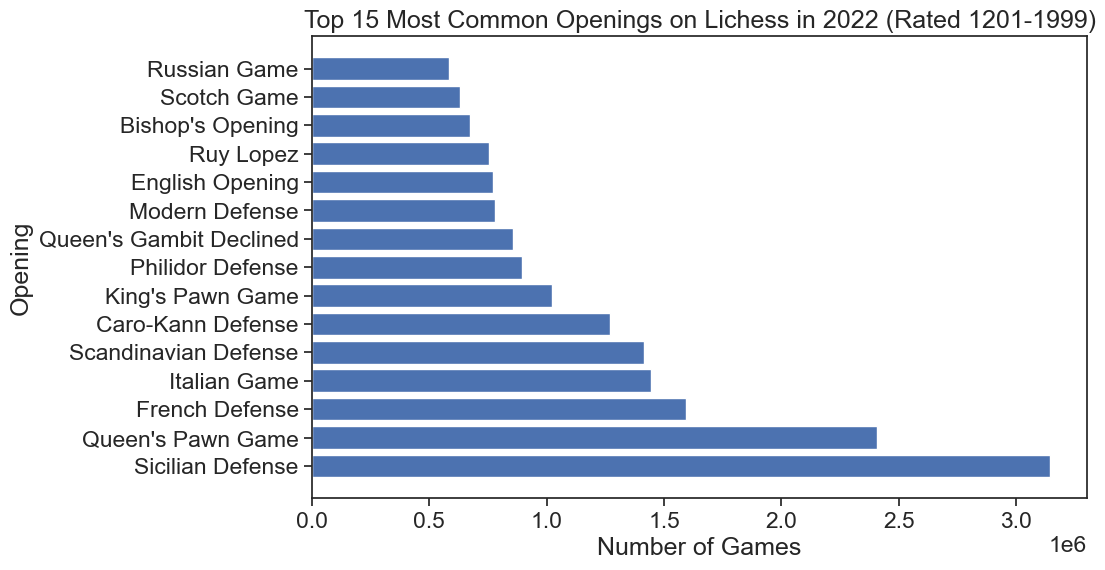

In [14]:
# Group variations of the same opening together by splitting on the colon.
mid_rated_opening_groups = (
    df[(df["WhiteElo"] >= 1201) & (df["WhiteElo"] <= 1999)]["Opening"]
    .str.split(":")
    .str[0]
    .value_counts()
    .compute()
)
display(mid_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
mid_rated_top_15_openings = mid_rated_opening_groups[:15]
mid_rated_top_15_openings_proportion = (
    mid_rated_top_15_openings.sum() / opening_groups.sum()
)
print(
    "The top 15 openings for players rated 1201-1999 account for "
    f"{mid_rated_top_15_openings_proportion:.2%} of all games on Lichess in 2022."
)

# Plot the top 15 most common openings.
sns.set("talk")
sns.set(font_scale=1.5)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = mid_rated_opening_groups.index[:15]
values = mid_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 1201-1999)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


### Low Rated Players (Rating 1200 and Below)


Queen's Pawn Game                         586993
King's Pawn Game                          583240
Scandinavian Defense                      330632
Sicilian Defense                          267560
Italian Game                              258579
                                           ...  
Veresov Opening                                2
Colle System                                   2
Amar Gambit                                    1
Queen's Pawn Game, Zukertort Variation         1
Marienbad System                               1
Name: Opening, Length: 160, dtype: int64

The top 15 openings for players rated 1200 and below account for 8.95% of all games on Lichess in 2022.


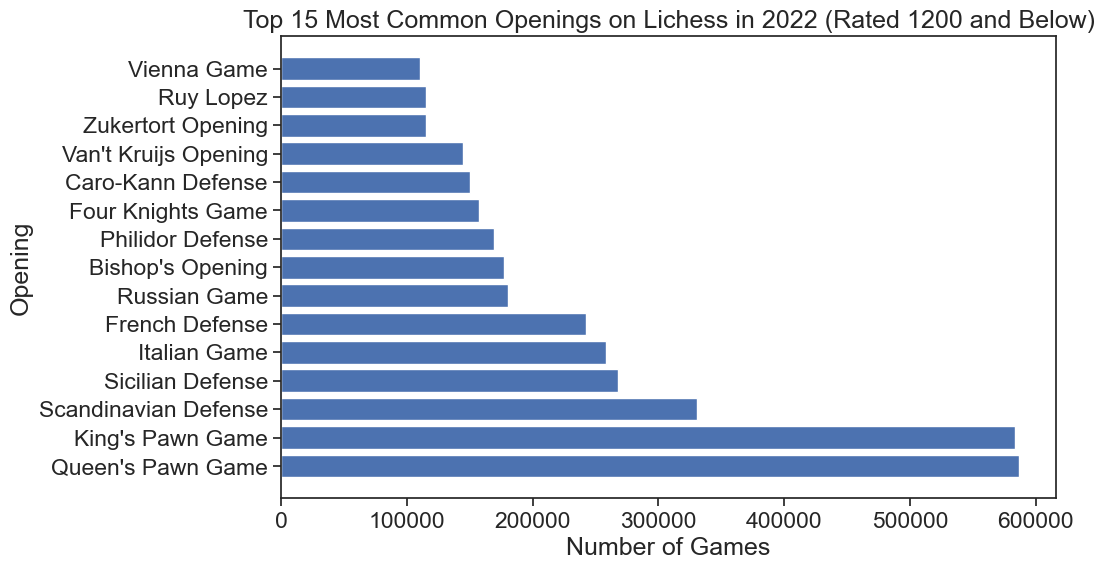

In [15]:
# Group variations of the same opening together by splitting on the colon.
low_rated_opening_groups = (
    df[df["WhiteElo"] <= 1200]["Opening"].str.split(":").str[0].value_counts().compute()
)
display(low_rated_opening_groups)

# Calculate what proportion of all games the top 15 openings account for.
low_rated_top_15_openings = low_rated_opening_groups[:15]
low_rated_top_15_openings_proportion = (
    low_rated_top_15_openings.sum() / opening_groups.sum()
)
print(
    "The top 15 openings for players rated 1200 and below account for "
    f"{low_rated_top_15_openings_proportion:.2%} of all games on Lichess in 2022."
)

# Plot the top 15 most common openings.
sns.set("talk")
sns.set(font_scale=1.5)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
indexes = low_rated_opening_groups.index[:15]
values = low_rated_opening_groups.values[:15]
ax.barh(indexes, values)
ax.set_title("Top 15 Most Common Openings on Lichess in 2022 (Rated 1200 and Below)")
ax.set_xlabel("Number of Games")
ax.set_ylabel("Opening")
plt.show()


## Create Columns for Rating Differential


In [16]:
# Create an EloDiff column to represent the difference in Elo between the two
# players.
df["EloDiff"] = df["WhiteElo"] - df["BlackElo"]
# Calculate the relative rating difference of of the higher rated player by
# calculating the median of the two players' ratings and finding what
# percentage the higher rated player is of the median.
df["RelativeEloDiff"] = df["WhiteElo"] / (df[["WhiteElo", "BlackElo"]].median(axis=1))
df["RelativeEloDiff"] = df["RelativeEloDiff"].round(4) - 1.0000

display(df.head())


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site,EloDiff,RelativeEloDiff
7,2022-01-01 00:00:11,Rated Rapid game,600+0,1-0,Normal,B00,"Nimzowitsch Defense: Scandinavian Variation, A...",shahzad97,mpasha98,1500,1205,https://lichess.org/UMMGcaGz,295,0.1091
8,2022-01-01 00:00:11,Rated Blitz game,300+3,0-1,Normal,D00,Queen's Pawn Game: Mason Variation,nicolas_clos,pangma,1430,1412,https://lichess.org/yJI78ET0,18,0.0063
9,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,E97,"King's Indian Defense: Orthodox Variation, Aro...",oyuka79,JUAN121,2422,2292,https://lichess.org/mrPOJU0W,130,0.0276
10,2022-01-01 00:00:12,Rated Blitz game,300+0,1-0,Normal,C22,Center Game: Berger Variation,manoharkatwa,RigoBam,1241,1221,https://lichess.org/YJ1AIn03,20,0.0081
11,2022-01-01 00:00:12,Rated Blitz game,300+0,0-1,Time forfeit,A40,Modern Defense,raffrantic1,Carly001,1044,1091,https://lichess.org/RATgKCCm,-47,-0.0220


### Effect of Rating on Win Rate


In [17]:
# Count the number of games where White won.
num_white_wins = df[df["Result"] == "1-0"].shape[0].compute()
white_wins_proportion = num_white_wins / len(df)
print(
    f"White won {num_white_wins} out of {len(df)} games ({white_wins_proportion:.2%})."
)

# Count the number of games where the result was 1-0 when White had a higher
# rating.
num_white_wins_with_higher_rating = (
    df[(df["WhiteElo"] > df["BlackElo"]) & (df["Result"] == "1-0")].shape[0].compute()
)
num_games_with_higher_rated_white = (
    df[(df["WhiteElo"] > df["BlackElo"])].shape[0].compute()
)
white_wins_with_higher_rating_proportion = (
    num_white_wins_with_higher_rating / num_games_with_higher_rated_white
)
print(
    f"White won {num_white_wins_with_higher_rating} out of "
    f"{num_games_with_higher_rated_white} games "
    f"({white_wins_with_higher_rating_proportion:.2%}) when they had a higher rating."
)


White won 19938052 out of 40121728 games (49.69%).
White won 10662552 out of 19751086 games (53.98%) when they had a higher rating.


## Effect of Relative Rating on Win Rate


In [18]:
# Model whether the relative rating difference is correlated with an
# increased likelihood of White winning.
